In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.wkt import loads
import matplotlib.pyplot as plt

In [4]:
# Read the spatial grid data of mobile signaling data
df = pd.read_csv('grid_shanghai_hexin.csv')

# Read the urban area studied
neihuan_shp = gpd.read_file('shanghai_zhonghuan.shp')

# rename the column containing geometric information
df['geometry'] = df['wkt'].apply(loads)

# create GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.set_crs(epsg=4326, inplace=True)

# select the grids within the study area
gdf['within_neihuan'] = gdf.geometry.apply(lambda geom: neihuan_shp.contains(geom).all())
gdf_within = gdf[gdf['within_neihuan']][['grid_id', 'geometry']]

In [5]:
gdf_within

,grid_id,geometry
1,wtw37ct,"POLYGON ((121.46072 31.16547, 121.46210 31.165..."
2,wtw375v,"POLYGON ((121.42776 31.17783, 121.42914 31.177..."
4,wtw35p7,"POLYGON ((121.42502 31.15311, 121.42639 31.153..."
6,wtw3771,"POLYGON ((121.43326 31.17371, 121.43463 31.173..."
7,wtw35jy,"POLYGON ((121.42914 31.14487, 121.43051 31.144..."
...,...,...
44513,wtw3dw8,"POLYGON ((121.39893 31.23688, 121.40030 31.236..."
44514,wtw3g1v,"POLYGON ((121.42776 31.25473, 121.42914 31.254..."
44515,wtw3f0m,"POLYGON ((121.38382 31.24649, 121.38519 31.246..."
44519,wtw3dsk,"POLYGON ((121.40442 31.22452, 121.40579 31.224..."


In [6]:
gdf_within.to_file('shanghai_core.shp')
grid = gpd.read_file('shanghai_core.shp') 

In [11]:
# read urban building data
buildings = gpd.read_file('shanghai_final_building_1229.shp') 

In [12]:
# Set the correct projection coordinate system.
grid = grid.to_crs(epsg=32651)
buildings = buildings.to_crs(epsg=32651)

In [14]:
# Fix invalid geometry.
grid["geometry"] = grid.geometry.apply(lambda x: x.buffer(0) if not x.is_valid else x)
buildings["geometry"] = buildings.geometry.apply(lambda x: x.buffer(0) if not x.is_valid else x)

# check
invalid_geometries_grid = grid[~grid.geometry.is_valid]
invalid_geometries_buildings = buildings[~buildings.geometry.is_valid]

print(f"Grid 中无效几何数量: {len(invalid_geometries_grid)}")
print(f"Buildings 中无效几何数量: {len(invalid_geometries_buildings)}")


Grid 中无效几何数量: 0
Buildings 中无效几何数量: 0


In [17]:
# Delete grids that do not include buildings.


buildings_sindex = buildings.sindex

possible_matches_index = grid.geometry.apply(
    lambda x: list(buildings_sindex.intersection(x.bounds))
)

overlap_mask = [
    any(grid.geometry.iloc[idx].intersects(buildings.geometry.iloc[j]) for j in indices)
    for idx, indices in enumerate(possible_matches_index)
]

grid_clean = grid[overlap_mask]

In [18]:
# Calculate the area of footprint geometry in each row and store the results in the 'f_area' column.
buildings['f_area'] = buildings.geometry.area

# Use the `overlay` method for spatial clipping.
cut_buildings = gpd.overlay(buildings, grid, how='intersection')

# Calculate the area of the clipped footprint geometry in each row and store the results in the 'c_area' column.
cut_buildings['c_area'] = cut_buildings.geometry.area

C:\Users\3ATHU-ACCOUNT-1\AppData\Local\Temp\ipykernel_71992\2716253323.py:5: UserWarning: `keep_geom_type=True` in overlay resulted in 5 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  cut_buildings = gpd.overlay(buildings, grid, how='intersection')


In [20]:
grid_clean

,grid_id,geometry
0,wtw37ct,"POLYGON ((353297.463 3448959.960, 353299.580 3..."
1,wtw375v,"POLYGON ((350175.367 3450374.150, 350177.530 3..."
2,wtw35p7,"POLYGON ((349874.614 3447637.806, 349876.779 3..."
3,wtw3771,"POLYGON ((350692.428 3449910.046, 350694.583 3..."
4,wtw35jy,"POLYGON ((350254.405 3446718.874, 350256.564 3..."
...,...,...
15454,wtw3dw8,"POLYGON ((347521.640 3456959.358, 347523.847 3..."
15455,wtw3g1v,"POLYGON ((350296.633 3458898.861, 350298.801 3..."
15456,wtw3f0m,"POLYGON ((346098.418 3458045.915, 346100.646 3..."
15457,wtw3dsk,"POLYGON ((348025.058 3455581.734, 348027.256 3..."


In [21]:
cut_buildings

,b_id,面积,f_area,height,FLOOR,Cate,grid_id,geometry,c_area
0,142057,157174.489717,81511.462407,666,6,residential,wtw3kt2,"POLYGON ((355942.129 3451359.553, 355948.206 3...",12019.601286
1,142057,157174.489717,81511.462407,666,6,residential,wtw3ksb,"POLYGON ((355933.173 3450902.918, 355915.055 3...",3555.231542
2,142057,157174.489717,81511.462407,666,6,residential,wtw3kmz,"POLYGON ((355820.545 3451560.298, 355816.155 3...",1323.254717
3,142057,157174.489717,81511.462407,666,6,residential,wtw3kt1,"POLYGON ((355968.547 3451206.940, 355995.297 3...",5534.928471
4,142057,157174.489717,81511.462407,666,6,residential,wtw3ksc,"POLYGON ((355995.297 3451054.321, 356003.304 3...",9904.276391
...,...,...,...,...,...,...,...,...,...
200070,230175,89.633939,33.683924,18,None,residential,wtw3w3p,"POLYGON ((364122.987 3453462.379, 364122.354 3...",33.683924
200071,48607,96.143156,53.889358,12,4,residential,wtw36tm,"POLYGON ((348193.804 3451443.006, 348197.085 3...",53.889358
200072,150500,59.435032,39.187831,12,8,residential,wtw3seu,"POLYGON ((356445.858 3455248.588, 356440.884 3...",39.187831
200073,243514,40.197124,25.345024,13,None,residential,wtw3wgk,"POLYGON ((365934.162 3454833.860, 365935.309 3...",25.345024


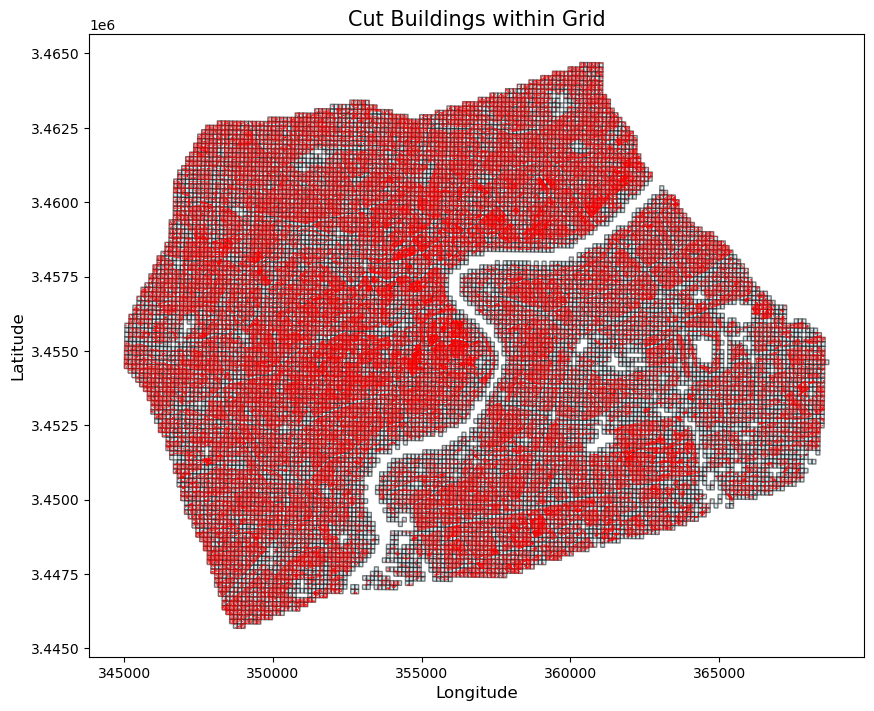

In [23]:
# Visualize the grid and the clipped building footprints.
fig, ax = plt.subplots(figsize=(10, 10))
grid_clean.plot(ax=ax, edgecolor='black', facecolor='lightblue', alpha=0.5)

cut_buildings.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=0.2)

ax.set_title('Cut Buildings within Grid', fontsize=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

plt.show()

In [27]:
# read mobile signaling data
cdr = pd.read_csv('shanghai_final_20231016_22.csv')

In [28]:
cdr.head()

,day,hour,home,work,other,grid_id
0,20231016,15,740,92,83,wtw318d
1,20231016,15,75,16,33,wtw31fr
2,20231016,15,197,233,575,wtw31rf
3,20231016,15,39,78,46,wtw33bt
4,20231016,15,209,78,111,wtw33d6


In [34]:
# Filter signaling data to retain only grid_ids that are within valid_grid_ids.

valid_grid_ids = grid_clean['grid_id']
filtered_cdr = cdr[cdr['grid_id'].isin(valid_grid_ids)]

In [42]:
grid_clean.to_file('grid_clean.shp')
filtered_cdr.to_csv('filtered_shanghai_final_20240513_19.csv')

In [43]:
cut_buildings.to_file('cut_buildings_1.shp', encoding='utf-8' )

In [45]:
cut_buildings = gpd.read_file('cut_buildings_1.shp')

In [48]:
cut_buildings

,b_id,面积,f_area,height,FLOOR,Cate,grid_id,c_area,geometry,New_Cate,Sub_Cate
0,142057,157174.489717,81511.462407,666,6,residential,wtw3kt2,12019.601286,"POLYGON ((355942.129 3451359.553, 355948.206 3...",Residential,Residential
1,142057,157174.489717,81511.462407,666,6,residential,wtw3ksb,3555.231542,"POLYGON ((355933.173 3450902.918, 355915.055 3...",Residential,Residential
2,142057,157174.489717,81511.462407,666,6,residential,wtw3kmz,1323.254717,"POLYGON ((355820.545 3451560.298, 355816.155 3...",Residential,Residential
3,142057,157174.489717,81511.462407,666,6,residential,wtw3kt1,5534.928471,"POLYGON ((355968.547 3451206.940, 355995.297 3...",Residential,Residential
4,142057,157174.489717,81511.462407,666,6,residential,wtw3ksc,9904.276391,"POLYGON ((355995.297 3451054.321, 356003.304 3...",Residential,Residential
...,...,...,...,...,...,...,...,...,...,...,...
200070,230175,89.633939,33.683924,18,None,residential,wtw3w3p,33.683924,"POLYGON ((364122.987 3453462.379, 364122.354 3...",Residential,Residential
200071,48607,96.143156,53.889358,12,4,residential,wtw36tm,53.889358,"POLYGON ((348193.804 3451443.006, 348197.085 3...",Residential,Residential
200072,150500,59.435032,39.187831,12,8,residential,wtw3seu,39.187831,"POLYGON ((356445.858 3455248.588, 356440.884 3...",Residential,Residential
200073,243514,40.197124,25.345024,13,None,residential,wtw3wgk,25.345024,"POLYGON ((365934.162 3454833.860, 365935.309 3...",Residential,Residential


In [49]:
cut_buildings.to_file('cut_buildings.shp', encoding='utf-8')

In [50]:
cut_buildings = gpd.read_file('cut_buildings.shp')

columns_to_keep = ['b_id', 'grid_id', 'geometry', '面积', 'f_area', 'c_area',  'Cate', 'New_Cate', 'Sub_Cate']

# create GeoDataFrame, delete useless columns
final_buildings = cut_buildings[columns_to_keep]

In [51]:
# Calculate the area of the clipped buildings in different grids
final_buildings.loc[:, 'total_area'] = final_buildings['面积'] * final_buildings['c_area'] / final_buildings['f_area']


C:\ProgramData\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [52]:
final_buildings

,b_id,grid_id,geometry,面积,f_area,c_area,Cate,New_Cate,Sub_Cate,total_area
0,142057,wtw3kt2,"POLYGON ((355942.129 3451359.553, 355948.206 3...",157174.489717,81511.462407,12019.601286,residential,Residential,Residential,23176.797998
1,142057,wtw3ksb,"POLYGON ((355933.173 3450902.918, 355915.055 3...",157174.489717,81511.462407,3555.231542,residential,Residential,Residential,6855.375758
2,142057,wtw3kmz,"POLYGON ((355820.545 3451560.298, 355816.155 3...",157174.489717,81511.462407,1323.254717,residential,Residential,Residential,2551.566107
3,142057,wtw3kt1,"POLYGON ((355968.547 3451206.940, 355995.297 3...",157174.489717,81511.462407,5534.928471,residential,Residential,Residential,10672.726661
4,142057,wtw3ksc,"POLYGON ((355995.297 3451054.321, 356003.304 3...",157174.489717,81511.462407,9904.276391,residential,Residential,Residential,19097.922449
...,...,...,...,...,...,...,...,...,...,...
200070,230175,wtw3w3p,"POLYGON ((364122.987 3453462.379, 364122.354 3...",89.633939,33.683924,33.683924,residential,Residential,Residential,89.633939
200071,48607,wtw36tm,"POLYGON ((348193.804 3451443.006, 348197.085 3...",96.143156,53.889358,53.889358,residential,Residential,Residential,96.143156
200072,150500,wtw3seu,"POLYGON ((356445.858 3455248.588, 356440.884 3...",59.435032,39.187831,39.187831,residential,Residential,Residential,59.435032
200073,243514,wtw3wgk,"POLYGON ((365934.162 3454833.860, 365935.309 3...",40.197124,25.345024,25.345024,residential,Residential,Residential,40.197124


In [55]:
final_buildings.to_file('final_buildings.shp', encoding='utf-8')

# Write the standard reference occupancy patterns 

In [4]:
final_buildings = gpd.read_file('final_buildings.shp')

In [5]:
# Write the standard reference occupancy patterns of a typical week into each row based on building types.
# Signaling data is missing data for 0 o'clock, which will be supplemented at the end. Therefore, each day has only 23 data points, divided into weekdays and weekends, totaling 46 data points.


values_dict = {
    'School': [0,0,0,0,0,0,0.348876404494382,0.348876404494382,0.348876404494382,0.348876404494382,0.348876404494382,0.348876404494382,0.348876404494382,0.348876404494382,0.348876404494382,0.348876404494382,0,0,0,0,0,0,0,
              0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    'University': [0,0,0,0,0,0,0.0347380771823635,0.496258245462335,0.496258245462335,0.496258245462335,0.496258245462335,0.496258245462335,0.496258245462335,0.496258245462335,0.496258245462335,0.496258245462335,0.496258245462335,0.124064561365584,0.124064561365584,0.124064561365584,0.124064561365584,0.0347380771823635,0, 
                   0,0,0,0,0,0,0,0.186096842048376,0.186096842048376,0.186096842048376,0.186096842048376,0.186096842048376,0.186096842048376,0.124064561365584,0.124064561365584,0.124064561365584,0.124064561365584,0.0620322806827919,0.0620322806827919,0.0620322806827919,0.0620322806827919,0,0],
    
    'Residential': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    'Other': [0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,
               0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02],
    'Industrial': [0,0,0,0,0,0,0.01,0.02,0.02,0.02,0.02,0.005,0.02,0.02,0.02,0.02,0.02,0.01,0,0,0,0,0,
               0,0,0,0,0,0,0.001,0.002,0.002,0.002,0.002,0.0005,0.002,0.002,0.002,0.002,0.002,0.001,0,0,0,0,0],
    
    'Office': [0,0,0,0,0,0,0.00838972733893043,0.0419486366946522,0.107011676915482,0.107011676915482,0.106691220486621,0.0264510077322353,0.0854995555336094,0.10621053584333,0.106691220486621,0.106691220486621,0.0854995555336094,0.0435509188389572,0.0256498666600828,0.0128249333300414,0.00427497777668047,0,0,
               0,0,0,0,0,0,0.000419486366946522,0.00209743183473261,0.00535058384577411,0.00535058384577411,0.00533456102433106,0.00132255038661177,0.00427497777668047,0.00531052679216649,0.00533456102433106,0.00533456102433106,0.00427497777668047,0.00217754594194786,0.00128249333300414,0.00064124666650207,0.000213748888834023,0,0],

    
    'Hospital': [0.0226245823593051,0.0222239313913431,0.0222239313913431,0.0222239313913431,0.0218232804233812,0.0402501258980027,0.0454156464659649,0.119379680054566,0.125443897464368,0.129486709070902,0.117914538169198,0.0940376254231058,0.103764697546327,0.115336868448031,0.119379680054566,0.109272651038229,0.0587375059565451,0.0279587719378117,0.0258297901030006,0.0250284881670767,0.0242271862311528,0.0234258842952289,0.0234258842952289,
                0.0226245823593051,0.0222239313913431,0.0222239313913431,0.0222239313913431,0.0218232804233812,0.0271574700018878,0.0279587719378117,0.0356281363308498,0.0361089174924041,0.0364294382667737,0.0341629944454823,0.0288975358602158,0.0330411717351889,0.0353076155564802,0.0356281363308498,0.0348268343949259,0.0308203247153066,0.0279587719378117,0.0258297901030006,0.0250284881670767,0.0242271862311528,0.0234258842952289,0.0234258842952289],
    
    'Mixed1': [0,0,0,0,0,0,0.00638626280874666,0.0339418179579483,0.077885254229173,0.0990823291607706,0.097050094610957,
               0.048746617230151,0.0878648351115123,0.0985606214079872,0.101010473767126,0.0926865950202796,0.0909459012707858,
               0.0750177044252709,0.0658606329377625,0.0490155324857945,0.0266693113207755,0.00360335916585185,0,
               
              0,0,0,0,0,0,0.000527753691156148,0.0121642399615583,0.0346764975263336,0.0624944431009893,0.0535492636655076,
               0.0488863440400341,0.0587949059851079,0.0536258217540568,0.0508772470675707,0.0380470607339203,0.0398861857677183,
               0.0666880313961348,0.0683501119583395,0.0538767964079164,0.0165942603709505,0.00554362948592592,0],
   
    'Mixed3': [0.00550936449871381,0.00550936449871381,0.00550936449871381,0.00550936449871381,0.00550936449871381,0.00550936449871381,
               0.0127574238342941,0.034059166877225,0.061540552200936,0.0626467188534931,0.0655952438231158,0.023942933696921,
               0.0495858390845912,0.061263884861926,0.0613222497347879,0.0618329218707288,0.057274319433828,0.0311241857128393,
               0.0255329372339605,0.0224737453287338,0.0202410193289601,0.00771470495471197,0.00550936449871381,
               
              0.00550936449871381,0.00550936449871381,0.00550936449871381,0.00550936449871381,0.00550936449871381,0.00550936449871381,
               0.00823009824483577,0.0110622223098418,0.0177949582987707,0.0185187259631745,0.0192724572459208,0.0129245371909977,
               0.016248522187211,0.0154728976359497,0.0136228268002408,0.0132157413646137,0.0122270742969392,0.0124559863879866,
               0.0139987433568394,0.0132339453805327,0.00870682545183906,0.00703896045132718,0.00550936449871381],
    
    'Retail': [0,0,0,0,0,0,0.00369575299061728,0.0251804446671364,0.050193309450487,0.120850225889146,0.114592556422585,0.107647572186948,0.114382658155565,0.120402314295247,0.127793820276482,0.100047557786994,0.124652878686477,0.159517837727452,0.165985405461032,0.109835070621139,0.0353476667377422,0.0120111972195062,0,
                0,0,0,0,0,0,0.005,0.0317515716859253,0.0946459046231031,0.187372389871955,0.157606769656965,0.157470364942091,0.178133007395412,0.157939430140385,0.148700047663842,0.105932759885007,0.115103940004113,0.213239320284771,0.222478702761314,0.174234317593237,0.0499591974700173,0.0184787649530864,0],
    
    'Culture': [0,0,0,0,0,0,0,0.01,0.02,0.08,0.08,0.02,0.08,0.08,0.08,0.08,0.04,0.02,0,0,0,0,0,
               0,0,0,0,0,0,0,0.01,0.05,0.15,0.15,0.04,0.15,0.15,0.15,0.15,0.08,0.02,0,0,0,0,0],
    
    'Gym': [0,0,0,0,0,0,0,0.01,0.02,0.04,0.04,0.02,0.04,0.04,0.04,0.04,0.04,0.02,0.08,0.08,0.02,0,0,
               0,0,0,0,0,0,0,0.01,0.05,0.1,0.1,0.05,0.1,0.1,0.1,0.1,0.1,0.04,0.08,0.08,0.02,0,0],

    'Transport': [0.01,0.01,0.01,0.01,0.01,0.01,0.05,0.2,0.2,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.2,0.2,0.1,0.1,0.01,0.01,
               0.01,0.01,0.01,0.01,0.01,0.01,0.05,0.1,0.1,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.1,0.01,0.01],
    
    'Hotel': [0.0471976678578146,0.0471976678578146,0.0471976678578146,0.0471976678578146,0.0471976678578146,0.0471976678578146,0.0478559337972541,0.0242570998683468,0.0242570998683468,0.014685913108896,0.014685913108896,0.00537803272522099,0.0242570998683468,0.0242570998683468,0.0148175662967839,0.0144884333270641,0.00504889975550122,0.00524637953733308,0.0148175662967839,0.0148175662967839,0.014620086514952,0.0471976678578146,0.0471976678578146,
              0.0471976678578146,0.0471976678578146,0.0471976678578146,0.0471976678578146,0.0471976678578146,0.0471976678578146,0.0478559337972541,0.0242570998683468,0.0242570998683468,0.014685913108896,0.014685913108896,0.00537803272522099,0.0242570998683468,0.0242570998683468,0.0148175662967839,0.0144884333270641,0.00504889975550122,0.00524637953733308,0.0148175662967839,0.0148175662967839,0.014620086514952,0.0471976678578146,0.0471976678578146],
    
    'Mixed2': [0.0110187289974276,0.0110187289974276,0.0110187289974276,0.0110187289974276,0.0110187289974276,0.0110187289974276,0.0179755092235003,0.0304216415290109,0.0333278738389763,0.0355402071440905,0.041658590954544,0.0243825165737467,0.0226716243622643,0.0333278738389763,0.0331126027778882,0.03413394704977,0.0380485850607379,0.0234450098441996,0.0281158583258456,0.0219974745153921,0.0175320225158448,0.0154294099094239,0.0110187289974276,
              0.0110187289974276,0.0110187289974276,0.0110187289974276,0.0110187289974276,0.0110187289974276,0.0110187289974276,0.0157062626451627,0.0183547753971397,0.0266145935412519,0.0280621288700594,0.0295917248226728,0.0234987392999858,0.0248470389937301,0.0220258056834118,0.0182924639313129,0.0174782930600587,0.0168041432131865,0.0210316366178254,0.0257024850994713,0.0241728891468579,0.0151186492894706,0.0140779209026544,0.0110187289974276]
}



for index, row in final_buildings.iterrows():
    total_area = row['total_area']
    sub_cate = row['Sub_Cate']
    
    if sub_cate in values_dict:
        values = values_dict[sub_cate]
        
        # write weekday patterns C_0_1 ~ C_0_23
        for i in range(23):
            final_buildings.at[index, f'C_0_{i+1}'] = total_area * values[i]
        
        # write weekend patterns C_1_1 ~ C_1_23
        for i in range(23):
            final_buildings.at[index, f'C_1_{i+1}'] = total_area * values[i + 23]

In [6]:
# check
column_names = final_buildings.columns.tolist()
print(column_names)

['b_id', 'grid_id', '面积', 'f_area', 'c_area', 'Cate', 'New_Cate', 'Sub_Cate', 'total_area', 'geometry', 'C_0_1', 'C_0_2', 'C_0_3', 'C_0_4', 'C_0_5', 'C_0_6', 'C_0_7', 'C_0_8', 'C_0_9', 'C_0_10', 'C_0_11', 'C_0_12', 'C_0_13', 'C_0_14', 'C_0_15', 'C_0_16', 'C_0_17', 'C_0_18', 'C_0_19', 'C_0_20', 'C_0_21', 'C_0_22', 'C_0_23', 'C_1_1', 'C_1_2', 'C_1_3', 'C_1_4', 'C_1_5', 'C_1_6', 'C_1_7', 'C_1_8', 'C_1_9', 'C_1_10', 'C_1_11', 'C_1_12', 'C_1_13', 'C_1_14', 'C_1_15', 'C_1_16', 'C_1_17', 'C_1_18', 'C_1_19', 'C_1_20', 'C_1_21', 'C_1_22', 'C_1_23']


# Calculate the sum of occupants in each grid on an hourly basis

In [7]:
# Calculate the sum of occupants in residential/industrial/commercial buidlings in each grid on an hourly basis 

# Calculate the sum of `C` for rows with the same `grid_id` where `New_Cate` is `Residential`, and write the result to a new column `R`.

for i in range(1, 24):
    # calculate the sum of C_0_i & C_1_i 
    total_c0 = final_buildings[final_buildings['New_Cate'] == 'Residential'].groupby('grid_id')[f'C_0_{i}'].sum()
    total_c1 = final_buildings[final_buildings['New_Cate'] == 'Residential'].groupby('grid_id')[f'C_1_{i}'].sum()

    # Write the sums into the new columns `R_0_i` and `R_1_i`.
    final_buildings[f'R_0_{i}'] = final_buildings['grid_id'].map(total_c0)
    final_buildings[f'R_1_{i}'] = final_buildings['grid_id'].map(total_c1)
    

# Calculate the sum of `C` for rows with the same `grid_id` where `New_Cate` is `Commercial`, and write the result to a new column `M`.

for i in range(1, 24):
    # calculate the sum of C_0_i & C_1_i
    total_c0 = final_buildings[final_buildings['New_Cate'] == 'Commercial'].groupby('grid_id')[f'C_0_{i}'].sum()
    total_c1 = final_buildings[final_buildings['New_Cate'] == 'Commercial'].groupby('grid_id')[f'C_1_{i}'].sum()

    # Write the sums into the new columns `M_0_i` and `M_1_i`.
    final_buildings[f'M_0_{i}'] = final_buildings['grid_id'].map(total_c0)
    final_buildings[f'M_1_{i}'] = final_buildings['grid_id'].map(total_c1)
    


# Calculate the sum of `C` for rows with the same `grid_id` where `New_Cate` is `Industrial`, and write the result to a new column `F`.

for i in range(1, 24):
    # calculate the sum of C_0_i & C_1_i
    total_c0 = final_buildings[final_buildings['New_Cate'] == 'Industrial'].groupby('grid_id')[f'C_0_{i}'].sum()
    total_c1 = final_buildings[final_buildings['New_Cate'] == 'Industrial'].groupby('grid_id')[f'C_1_{i}'].sum()

    # Write the sums into the new columns `F_0_i` and `F_1_i`.
    final_buildings[f'F_0_{i}'] = final_buildings['grid_id'].map(total_c0)
    final_buildings[f'F_1_{i}'] = final_buildings['grid_id'].map(total_c1)
    
    
# Calculate the sum of `C` for rows with the same `grid_id` where `New_Cate` is `Other`, and write the result to a new column `U`.

for i in range(1, 24):
    # calculate the sum of C_0_i & C_1_i
    total_c0 = final_buildings[final_buildings['New_Cate'] == 'Other'].groupby('grid_id')[f'C_0_{i}'].sum()
    total_c1 = final_buildings[final_buildings['New_Cate'] == 'Other'].groupby('grid_id')[f'C_1_{i}'].sum()

    # Write the sums into the new columns `U_0_i` and `U_1_i`.
    final_buildings[f'U_0_{i}'] = final_buildings['grid_id'].map(total_c0)
    final_buildings[f'U_1_{i}'] = final_buildings['grid_id'].map(total_c1)

C:\ProgramData\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
C:\ProgramData\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
C:\ProgramData\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

In [10]:
final_buildings = gpd.GeoDataFrame(final_buildings, geometry='geometry') 

# rename '面积' as 'area'
final_buildings = final_buildings.rename(columns={'面积': 'area'})

# save as Shapefile
shapefile_path = 'sh_final_buildings_schedule.shp'
final_buildings.to_file(shapefile_path, encoding='utf-8')

# Use signaling data to calculate the actual number of occupants in each building

In [14]:
import glob
final_buildings = gpd.read_file('sh_final_buildings_schedule.shp')  

# Check whether each row includes a valid geometric shape.
nan_geometry_rows = final_buildings[final_buildings.geometry.isna()]
print(nan_geometry_rows)

Empty GeoDataFrame
Columns: [b_id, grid_id, area, f_area, c_area, Cate, New_Cate, Sub_Cate, total_area, C_0_1, C_0_2, C_0_3, C_0_4, C_0_5, C_0_6, C_0_7, C_0_8, C_0_9, C_0_10, C_0_11, C_0_12, C_0_13, C_0_14, C_0_15, C_0_16, C_0_17, C_0_18, C_0_19, C_0_20, C_0_21, C_0_22, C_0_23, C_1_1, C_1_2, C_1_3, C_1_4, C_1_5, C_1_6, C_1_7, C_1_8, C_1_9, C_1_10, C_1_11, C_1_12, C_1_13, C_1_14, C_1_15, C_1_16, C_1_17, C_1_18, C_1_19, C_1_20, C_1_21, C_1_22, C_1_23, R_0_1, R_1_1, R_0_2, R_1_2, R_0_3, R_1_3, R_0_4, R_1_4, R_0_5, R_1_5, R_0_6, R_1_6, R_0_7, R_1_7, R_0_8, R_1_8, R_0_9, R_1_9, R_0_10, R_1_10, R_0_11, R_1_11, R_0_12, R_1_12, R_0_13, R_1_13, R_0_14, R_1_14, R_0_15, R_1_15, R_0_16, R_1_16, R_0_17, R_1_17, R_0_18, R_1_18, R_0_19, R_1_19, R_0_20, R_1_20, R_0_21, R_1_21, R_0_22, R_1_22, R_0_23, ...]
Index: []

[0 rows x 240 columns]


In [15]:
# Fill all NaN values with 0 to avoid errors.
final_buildings = final_buildings.fillna(0)

In [16]:
# Initialize an empty list to store all the results.

columns = [
    'day', 'hour', 'home', 'work', 'other', 'b_home', 'b_work', 'b_other', 'grid_id', 'b_id', 
    'final_Cate', 'New_Cate','Sub_Cate', 'total_area',  'C', 'Re_area', 'Co_area', 'Fa_area', 'Un_area', 'area'
]
result_data = []

# Read signaling data file. Use glob to handle possible batch reading of multiple files.
csv_files = glob.glob("filtered_shanghai_final_20231016_22.csv")

for csv_file in csv_files:
    grid_data = pd.read_csv(csv_file)
    
    # for each clipped building
    for _, building_row in final_buildings.iterrows():
        grid_id = building_row['grid_id']
        New_Cate = building_row['New_Cate']
        Sub_Cate = building_row['Sub_Cate']

        
        # Filter out the data with grid_id matching the current building.
        grid_rows = grid_data[grid_data['grid_id'] == grid_id]
        
        for _, grid_row in grid_rows.iterrows():
            day = grid_row['day']
            hour = grid_row['hour']
            home = grid_row['home']
            work = grid_row['work']
            other = grid_row['other']

            
            # 根据 day 和 hour 获取对应的 Co_area, Fa_area, Un_area
            # weekday, select the sum of occupants at that hour
            if 20231016 <= day <= 20231020:
                Re_area = building_row[f'R_0_{hour}'] if f'R_0_{hour}' in building_row else 0
                Co_area = building_row[f'M_0_{hour}'] if f'M_0_{hour}' in building_row else 0
                Fa_area = building_row[f'F_0_{hour}'] if f'F_0_{hour}' in building_row else 0
                if pd.isna(Fa_area):
                    print(f"Fa_area is NaN for grid_id: {grid_id}, hour: {hour}, building_row: {building_row}")
                Un_area = building_row[f'U_0_{hour}'] if f'U_0_{hour}' in building_row else 0
                C = building_row[f'C_0_{hour}'] if f'C_0_{hour}' in building_row else 0
            # weekend, select the sum of occupants at that hour
            elif 20231021 <= day <= 20231022:
                Re_area = building_row[f'R_1_{hour}'] if f'R_1_{hour}' in building_row else 0
                Co_area = building_row[f'M_1_{hour}'] if f'M_1_{hour}' in building_row else 0
                Fa_area = building_row[f'F_1_{hour}'] if f'F_1_{hour}' in building_row else 0
                if pd.isna(Fa_area):
                    print(f"Fa_area is NaN for grid_id: {grid_id}, hour: {hour}, building_row: {building_row}")
                Un_area = building_row[f'U_1_{hour}'] if f'U_1_{hour}' in building_row else 0
                C = building_row[f'C_1_{hour}'] if f'C_1_{hour}' in building_row else 0
            else:
                Re_area = Co_area = Fa_area = Un_area = 0 
                
                
                
            # calculate the actual number of occupants in the building
            # People at ‘home’ only visits residential buildings
            # people at ‘work’ visits commercial or industrial buildings
            # people at ‘other’ only visits commercial buildings
            if New_Cate == 'Residential' and Re_area > 0:
                b_home = home * C / Re_area
                b_work = 0
                b_other = 0
            elif New_Cate == 'Commercial' and (Co_area + Fa_area + Un_area) > 0:
                b_home = 0
                b_work = work * C / (Co_area + Fa_area + Un_area)
                b_other = other * C / (Co_area + Un_area) if Co_area + Un_area > 0 else 0
            elif New_Cate == 'Factory' and (Co_area + Fa_area + Un_area) > 0:
                b_home = 0
                b_work = work * C / (Co_area + Fa_area + Un_area)
                b_other = 0
            elif New_Cate == 'Unknown' and (Co_area + Fa_area + Un_area) > 0:
                b_home = 0
                b_work = work * C / (Co_area + Fa_area + Un_area)
                b_other = other * C / (Co_area + Un_area) if Co_area + Un_area > 0 else 0
            else:
                b_home = b_work = b_other = 0

                
            # Add the results to the list.
            result_data.append([
                day, hour, home, work, other, b_home, b_work, b_other, grid_id, building_row['b_id'], 
                building_row['Cate'], New_Cate, Sub_Cate, building_row['total_area'], 
                 C, Re_area, Co_area, Fa_area, Un_area, 
                building_row['area']
            ])

            
# Convert the accumulated results into a DataFrame and save it as a CSV.
result_df = pd.DataFrame(result_data, columns=columns)
result_df.to_csv('202310_sh_week.csv', index=False, encoding='utf-8')


In [17]:
# Merge the unified buildings split by different grids based on `b_id` to obtain the number of occupants in the complete building.
grouped_df = result_df.groupby(
    ['day', 'hour', 'b_id', 'area' ,'final_Cate', 'New_Cate', 'Sub_Cate'], 
    as_index=False
).agg({
    'b_home': 'sum',
    'b_work': 'sum',
    'b_other': 'sum'
})


# Indicators

In [ ]:
# calculate the sum of b_home, b_work, b_other, obtain the number of occupants in the complete building.
grouped_df['total_b'] = grouped_df['b_home'] + grouped_df['b_work'] + grouped_df['b_other']

# calculate hourly occupancy density of each building
grouped_df['per'] = grouped_df['total_b'] / grouped_df['area']

# obtain the maximum number of occupants in each building throughout the week
grouped_df['max_b'] = grouped_df.groupby('b_id')['total_b'].transform('max')

# calculate the maximum occupancy density of each building
grouped_df['max_d'] = grouped_df['max_b'] / grouped_df['area']

# calculate the hourly occupancy rate of each building, based on maximum number
grouped_df['ratio'] = grouped_df['total_b'] / grouped_df['max_b']



# save the result
grouped_df.to_csv('202310_sh_buildings_hourly_occupany.csv', index=False, encoding='utf-8')

# Data processing

In [20]:
import pandas as pd

df = pd.read_csv('202310_sh_buildings_hourly_occupany.csv')


# buildings with evident anomalies were removed to ensure the results are as accurate as possible.
rows_to_drop = df[
    ((df['per'] > 0.5) & (df['Sub_Cate'].isin(['School','University']))) |
    ((df['per'] > 0.3) & (df['Sub_Cate'].isin(['Retail', 'Mixed1', 'Culture','Hospital','Mixed3','Transport']))) |
    ((df['per'] > 0.15) & (df['Sub_Cate'].isin(['Office','Gym']))) |
    ((df['per'] > 0.08) & (df['Sub_Cate'].isin(['Hotel', 'Residential','Other','Industrial'])))
]


b_ids_to_drop = rows_to_drop['b_id']
df_cleaned = df[~df['b_id'].isin(b_ids_to_drop)]


In [ ]:
# Supplement 0-hour data, applicable only to cases where the dataset in this study lacks 0-hour data.
df = df_cleaned

df_filtered = df[(df['hour'] == 1) | (df['hour'] == 23)]

df_merged = df_filtered.groupby(['day', 'b_id']).agg({
    
    'area': 'first',
    'final_Cate': 'first',
    'New_Cate': 'first',
    'Sub_Cate': 'first',

    'b_home': 'mean',
    'b_work': 'mean',
    'b_other': 'mean',
    'total_b': 'mean',
    'max_b': 'mean',
    'ratio': 'mean',
    'PCA': 'mean',
    'baseline': 'mean',
    'per': 'mean',
}).reset_index()  

df_merged['hour'] = 0

df1 = pd.concat([df, df_merged], ignore_index=True)

In [ ]:
# 保存处理后的数据
df1.to_csv('final_202310_sh_buildings_hourly_occupany.csv', index=False)